02 非負値行列因子分解(NMF)
=======================

* `非負値行列因子分解`(NMF)：有用な特徴量を抽出することを目的とする教師なし学習手法

    * このアルゴリズムの動作は`PCA`と似ており、次元削減に用いることができる
    
    * 個々のデータポイントをいくつかの成分の重み付き和とちえ表現したい
    
    * `PCA`では、個々の成分はデータの分散を可能な限り説明する互いに直交した物でなければならなかった
    
    * `NMF`では、係数と成分が非負であること(成分とその係数が常にゼロ以上)であることが求められる
    
    * 従って、この方法は個々の特徴量が非負のデータにしか適用できない
    
    * 非負の成分を非負係数で重み付き和を取ると、非負にしかならない

* データを非負の重み付き和に分解する方法は、いくつもの独立した発生源から得られたデータを重ね合わせて作られるようなデータに対して有用

    * 例)複数の人が話している音声データや、多数の楽器からなる音楽
    
    * `NMF`を用いると、組み合わされたデータを作り上げているもとの成分を特定することができる
    
    * まとめると、`NMF`は、`PCA`よりも理解しやすい成分に分解してくれる
    
    * 負の成分や係数があると、お互いに打ち消してしまう理解しづらい挙動になるが、`NMF`にはそれがない
    
    * `PCA`では方向に意味がないため
    
* `NMF`を顔画像データセットに適用する前に、まず合成データで試してみる

## 1. NMFの合成データへの適用

* `NMF`が扱えるように、データが全て正であるようにしなければならない

    * これは、原点$(0, 0)$に対してどの位置にあるかということが、`NMF`では問題になることを意味する
    
    * 従って、抽出された非負の成分は、原点からデータへの方向だと考えることができる
    
* 以下のプロットは、2次元のトイデータに`NMF`を適用した結果である

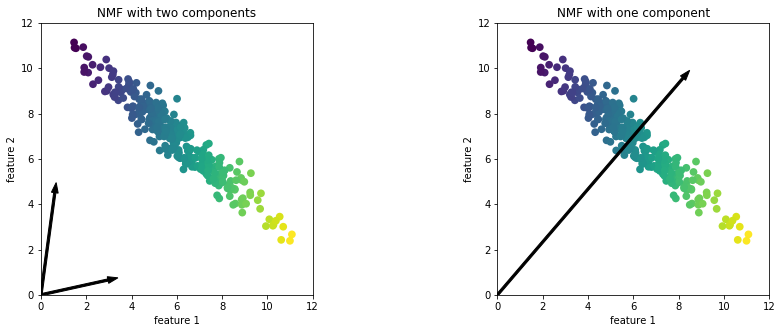

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mglearn
import numpy as np
mglearn.plots.plot_nmf_illustration()

* 左側に示した2成分の`NMF`では、全てのデータが2つの成分の正係数の重み付き和で表現できることが明らか

    * 完全にデータを再現するのに十分な数の成分がある場合には(特徴量と同じだけの成分がある場合には)、このアルゴリズムは極端な部分の方向を向く

* 1つしか成分を使わない場合には、`NMF`は、データの平均値へ向かう成分を作る

    * この点が、最もデータをよく説明する
    
    * `PCA`の場合と異なり、成分の数が変わると、いくつかの成分がなくなるのではなく、全く別の成分集合が構成される
    
    * また、`NMF`の成分は特定な順番で並んでいるわけではなく、全ての成分が同等

* `NMF`は、乱数初期化を用いる

    * このため、乱数シードが変わると結果が変わる場合がある
    
    * 2つの成分からなる合成データのような比較的簡単な場合には、全てのデータが完全に説明できるので、乱数性の影響は少ない
    
    * もっと複雑な場合には、乱数の影響はより大きくなる

## 2. NMFの顔画像への適用

* `NMF`を前にも使った`Labeled Faced in the Wild`データセットに適用してみる

* `NMF`の主要なパラメータは、いくつの成分を抽出するかを指定する

    * 通常この数は、入力特徴量の数よりも小さくなる
    
    * そうでないと、データのピクセルをそれぞれ成分にして説明することになってしまう
    
* まず、成分の数が`NMF`から再構成したデータの質に与える影響を見てみる

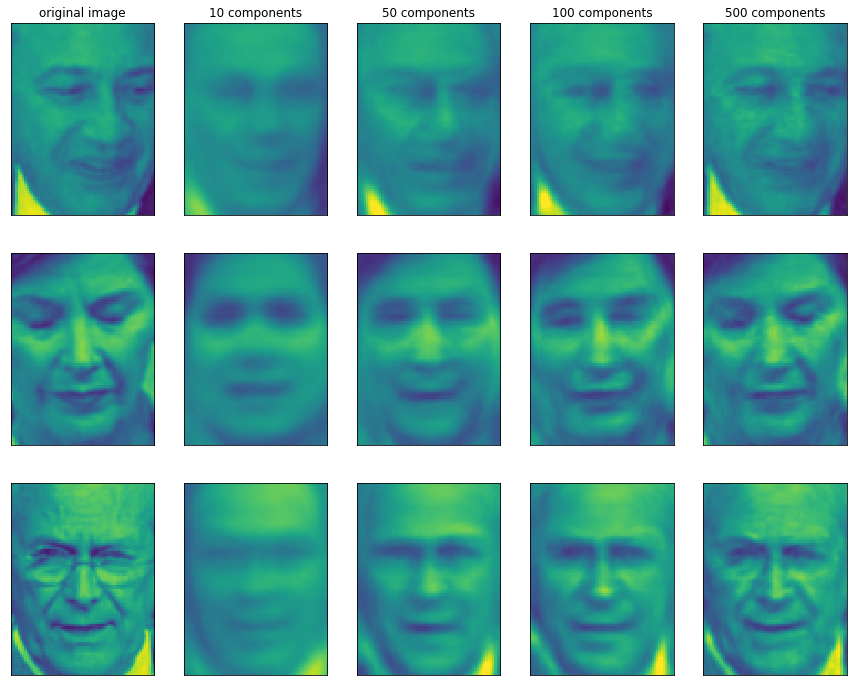

In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

image_shape = people.images[0].shape
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# 0から255で表現されている、グレースケールの値0と1の間に変換
# こうした方が、数値的に安定する
X_people = X_people / 255.

# 訓練セットとテストセットにデータを分割
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

* 逆変換したデータの質は、`PCA`を用いた時と似た傾向だが、少し悪い

    * `PCA`は再構成に最適な方向を見つけ出すので、これは予期したとおりである
    
    * `NMF`は再構成やデータのエンコードに用いられるよりは、データの中から興味深いパターンを見つけるのに用いられる
    
* データを見る手始めとして、最初の15成分を見てみる

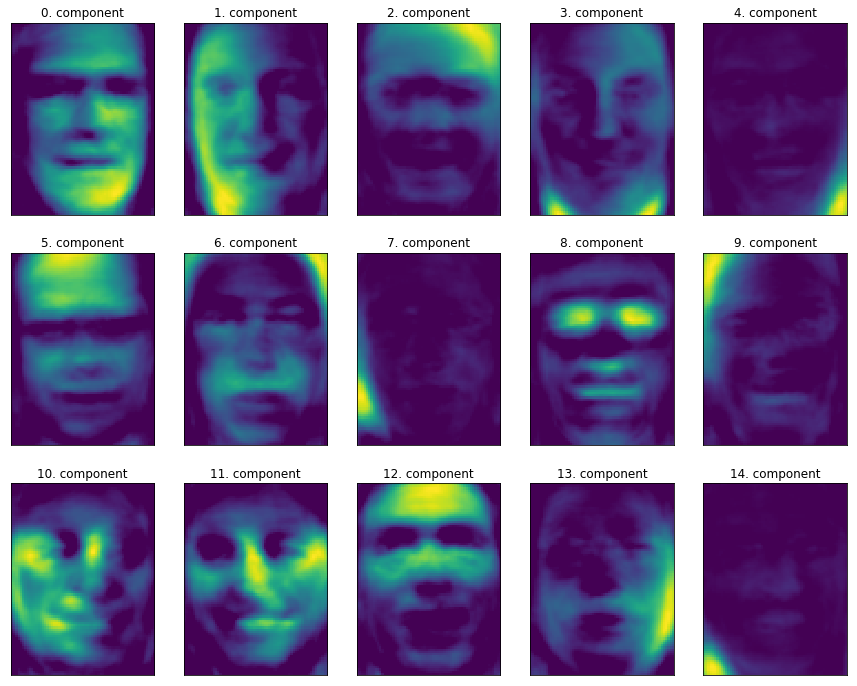

In [3]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fix, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

* 成分は全て正なので、`PCA`で得られた成分よりも遙かに顔のプロトタイプを捉えている

    * 例)成分3は少し右を向いた顔を、成分7は少し左を向いた顔を表している
    
    * 以下の図に、これらの成分が特に強い画像を見てみる

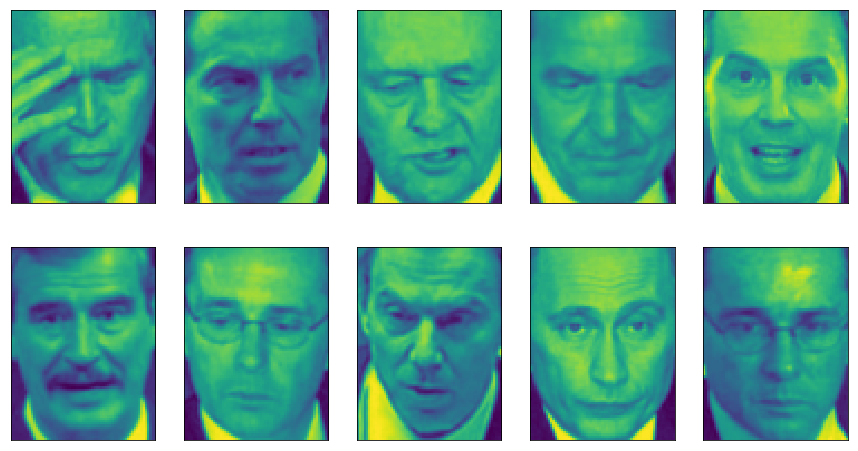

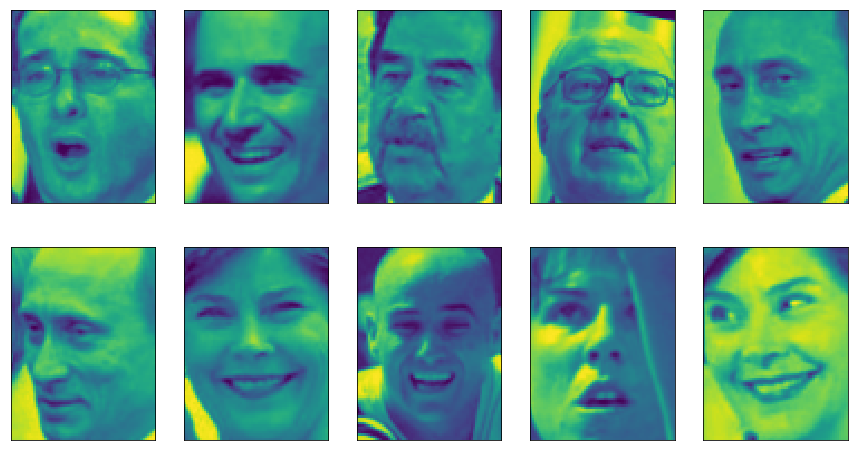

In [4]:
import numpy as np
compn = 3

# 3つ目の成分でソート、最初の10画像を表示
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))
    
compn = 7
# 7つ目の成分でソート、最初の10画像を表示
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

* 予想される通り、成分3の係数が大きい顔画像は右を向いており、成分7の係数が大きい顔画像は左を向いている

    * このようなパターン抽出は、追加していく構造を持つデータに対して最もうまく機能する
    
    * 例)音声データ、遺伝子発現、テキストデータなど
    
* 合成データを例としてみてみる

    * 3つの信号源からの信号が組み合わされた信号に興味があるとする

Text(0, 0.5, 'Signal')

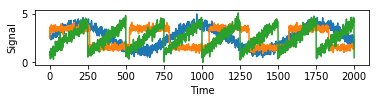

In [5]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel("Time")
plt.ylabel("Signal")

* これでは元の信号を観測することができず、この3つが混ざったものだけが観測できるとしよう

    * 混ざった信号を分解して、元の成分を取りだしてみる
    
    * 混合信号を観測する方法はたくさんあるとする(例:100計測機器があるとする)
    
    * それぞれから一連の計測結果が得られる

In [6]:
# データを混ぜて100次元の状態を作る
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("Shape of measurements: {}".format(X.shape))

Shape of measurements: (2000, 100)


* `NMF`を用いて、この3つの信号を復元することができる

In [7]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("Recovered signal shape: {}".format(S_.shape))

Recovered signal shape: (2000, 3)


* 比較のために`PCA`にも使ってみる

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
H = pca.fit_transform(X)

* 以下に、`NMF`と`PCA`が発した信号を示す

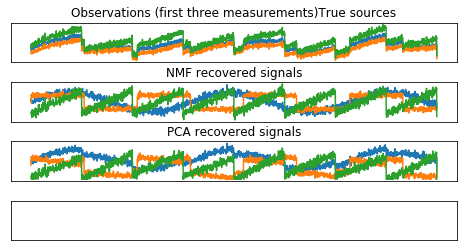

In [9]:
models = [X, S, S_, H]
names = ['Observations (first three measurements)'
         'True sources',
         'NMF recovered signals',
         'PCA recovered signals']

fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5}, subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')

* 一番上のプロットは、参照のため、100個の計測結果のうちの3つを示している

    * `NMF`は元の信号源をかなりうまく特定できていることがわかる
    
    * `PCA`は第1主成分をデータの大きな変動を説明するのに使っており、信号源の特定には失敗している
    
    * `NMF`が生成する成分には順番がないことに注意する
    


* `PCA`や`NMF`と同じように、個々のデータポイントを固定数の成分集合の重み付き和に分解するのに利用できるアルゴリズムは、他にもたくさんある

    * `独立成分分析`(ICA)
    
    * `因子分析`(FA)
    
    * `スパースコーディング`

| 版 | 年/月/日 |
|----|----------|
|初版|2019/03/17|